In [39]:
import numpy
import matplotlib
import matplotlib.pyplot as mp
import pandas
import mpl_toolkits
from mpl_toolkits import basemap
import matplotlib.cm as cm
import netCDF4
import time
#import itertools

mp.rcParams.update({'mathtext.default': 'regular'})
% matplotlib inline

In [2]:
class MidpointNormalize(matplotlib.colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return numpy.ma.masked_array(numpy.interp(value, x, y))

In [3]:
# make color map
minval=0.05 # 
maxval=0.95 #
n=256
full_cmap = mp.get_cmap('RdBu')
cmap_partial = matplotlib.colors.LinearSegmentedColormap.from_list('trunc({n},{a:.2f},{b:.2f})'.format(n=full_cmap.name, a=minval, b=maxval), full_cmap(numpy.linspace(minval, maxval, n)))

In [4]:
SKIP_LONS = []#[120.,240.]
def format_every_other(lon):
    if lon in SKIP_LONS:
        return ''
    else:
        return '%3d' % lon + '\N{DEGREE SIGN}E' #r'${%3d\/^{\circ}\/E}$'%lon

In [5]:
whiplash_segments = numpy.array(( \
'1920-1950', \
'1950-1980', \
'1980-2010', \
'2010-2040', \
'2040-2070', \
'2070-2100', \
))

In [7]:
PRECT_lat = numpy.load('/Users/baird/Dropbox/_analysis/attribution_2017/NEW_CALCULATIONS/npy_files/PRECT_lat.npy')
PRECT_lon = numpy.load('/Users/baird/Dropbox/_analysis/attribution_2017/NEW_CALCULATIONS/npy_files/PRECT_lon.npy')

In [10]:
all_csv_data = []
for i in range(whiplash_segments.size):
    all_csv_data.append(pandas.read_csv('csv_files_ALL_TIME/store_all_whiplash_ratios_dataframe_8020_whole_domain_'+whiplash_segments[i]+'_windowsize_1.csv'))

all_wr_data_2d = []
for i in range(whiplash_segments.size):
        all_wr_data_2d.append( all_csv_data[i].values[:,1].reshape((26,25)) )

# 80-20 plots

/Users/baird/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/Users/baird/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3608: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/baird/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3644: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  xx = x[x.shape[0]/2,:]
/Users/baird/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3677: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/Users/baird/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:350

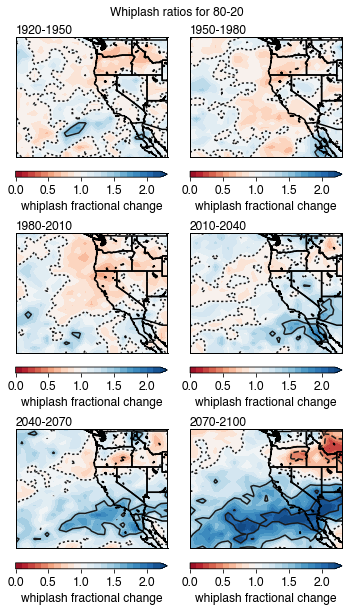

In [11]:
fontsize=12
contour_levels = numpy.arange(0,2.21,0.1)


fig = mp.figure(figsize=(5,8.5))

for i in range(whiplash_segments.size):
    ax = fig.add_subplot(3,2,i+1)
    map = basemap.Basemap(projection='cyl',ax=ax, llcrnrlat=PRECT_lat.min(),urcrnrlat=PRECT_lat.max(),llcrnrlon=PRECT_lon.min(),urcrnrlon=PRECT_lon.max(),resolution='i')
    map.fillcontinents(color='0.75',lake_color='0.5')
    # draw parallels and meridians. # labels[left, right, top, bottom]
    #map.drawparallels(numpy.arange(-80.,81.,5.), labels=[1,0,0,0], dashes=[3,2], fontsize=fontsize, color='0')
    #map.drawmeridians(numpy.arange(-180.,181.,10.), labels=[0,0,0,1], dashes=[3,2], fmt=format_every_other, fontsize=fontsize, color='0')
    map.drawmapboundary(fill_color='0')

    map.drawcoastlines(linewidth=1.5, color='0', zorder=3)
    #map.drawmapboundary(linewidth=1, color='0.5', zorder=3)
    map.drawstates(linewidth=1.5, color='0', zorder=3)
    map.drawcountries(linewidth=1.5, color='0', zorder=3)

    lons,lats = numpy.meshgrid(PRECT_lon, PRECT_lat)
    xi,yi = map(lons, lats)

    pr_map = map.contourf(xi, yi, all_wr_data_2d[i], cmap=cmap_partial, zorder=2, norm=MidpointNormalize(midpoint=1.0), levels=contour_levels, extend='max', latlon=True)
    pr_contours = map.contour(xi, yi, all_wr_data_2d[i], levels=[0.5,1.0,1.5,2.0], colors='0.1', alpha=1, linewidth=[1,1,1,1], linestyles=['--',':','-','-'])

    divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
    cbar_ax = divider.append_axes('bottom', size='5%', pad=0.2) #fig.add_axes([0.0, -0.02, 1.0, 0.03])
    #cbar = fig.colorbar(pr_map, cax=cbar_ax, orientation='horizontal', extend='max')
    cbar = fig.colorbar(pr_map, cax=cbar_ax, orientation='horizontal')

    cbar.set_label('whiplash fractional change', fontsize=fontsize)
    cbar.ax.tick_params(labelsize=fontsize)
    cbar.set_ticks([0,0.5,1.,1.5,2.])
    
    ax.text(s=whiplash_segments[i], x=0, y=1.01, transform=ax.transAxes, fontsize=fontsize, ha='left', va='bottom')

    fig.tight_layout()

fig.text(s='Whiplash ratios for 80-20', x=0.5, y=0.98, ha='center', va='bottom', fontsize=fontsize, transform=fig.transFigure)
mp.savefig('SIMPLE_whiplash_ratios_8020_all_segments.pdf', transparent=True, bbox_inches='tight')

In [34]:
csv_data = pandas.read_csv('csv_files_ALL_TIME/store_all_whiplash_ratios_dataframe_8020_whole_domain_2070-2100_windowsize_1.csv')
wr_data_2d_2070_2100 = csv_data.values[:,1].reshape((26,25))

# 80-20 plots for 2070-2100

/Users/baird/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/Users/baird/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3608: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/baird/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3644: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  xx = x[x.shape[0]/2,:]
/Users/baird/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3677: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/Users/baird/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:350

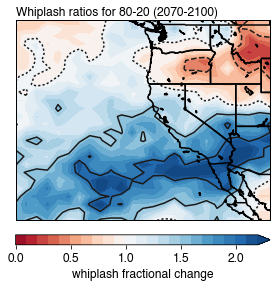

In [35]:
fontsize=12
contour_levels = numpy.arange(0,2.21,0.1)


fig = mp.figure(figsize=(4,4))

ax = fig.add_subplot(111)
map = basemap.Basemap(projection='cyl',ax=ax, llcrnrlat=PRECT_lat.min(),urcrnrlat=PRECT_lat.max(),llcrnrlon=PRECT_lon.min(),urcrnrlon=PRECT_lon.max(),resolution='i')
map.fillcontinents(color='0.75',lake_color='0.5')
map.drawmapboundary(fill_color='0')

map.drawcoastlines(linewidth=1.5, color='0', zorder=3)
map.drawstates(linewidth=1.5, color='0', zorder=3)
map.drawcountries(linewidth=1.5, color='0', zorder=3)

lons,lats = numpy.meshgrid(PRECT_lon, PRECT_lat)
xi,yi = map(lons, lats)

pr_map = map.contourf(xi, yi, wr_data_2d_2070_2100, cmap=cmap_partial, zorder=2, norm=MidpointNormalize(midpoint=1.0), levels=contour_levels, extend='max', latlon=True)
pr_contours = map.contour(xi, yi, wr_data_2d_2070_2100, levels=[0.5,1.0,1.5,2.0], colors='0.1', alpha=1, linewidth=[1,1,1,1], linestyles=['--',':','-','-'])

divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
cbar_ax = divider.append_axes('bottom', size='5%', pad=0.2) #fig.add_axes([0.0, -0.02, 1.0, 0.03])
cbar = fig.colorbar(pr_map, cax=cbar_ax, orientation='horizontal')

cbar.set_label('whiplash fractional change', fontsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_ticks([0,0.5,1.,1.5,2.])

ax.text(s='Whiplash ratios for 80-20 (2070-2100)', x=0, y=1.01, transform=ax.transAxes, fontsize=fontsize, ha='left', va='bottom')

fig.tight_layout()

#fig.text(s='Whiplash ratios for 80-20', x=0.5, y=0.98, ha='center', va='bottom', fontsize=fontsize, transform=fig.transFigure)
mp.savefig('SIMPLE_whiplash_ratios_8020_2070-2100.pdf', transparent=True, bbox_inches='tight')

# 80-20 plots (2003/2017/2032)

In [28]:
csv_data = pandas.read_csv('csv_files_ALL_TIME/store_all_whiplash_ratios_dataframe_8020_whole_domain_2003-2033_windowsize_1.csv')
wr_data_2d_2003_2033 = csv_data.values[:,1].reshape((26,25))

/Users/baird/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/Users/baird/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3608: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/baird/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3644: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  xx = x[x.shape[0]/2,:]
/Users/baird/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3677: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/Users/baird/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:350

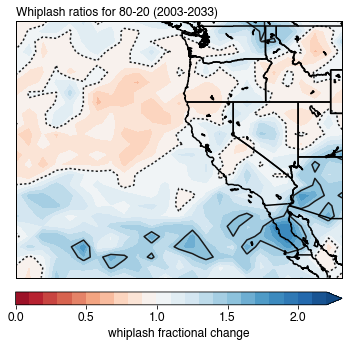

In [29]:
fontsize=12
contour_levels = numpy.arange(0,2.21,0.1)


fig = mp.figure(figsize=(5,5))

ax = fig.add_subplot(111)
map = basemap.Basemap(projection='cyl',ax=ax, llcrnrlat=PRECT_lat.min(),urcrnrlat=PRECT_lat.max(),llcrnrlon=PRECT_lon.min(),urcrnrlon=PRECT_lon.max(),resolution='i')
map.fillcontinents(color='0.75',lake_color='0.5')
map.drawmapboundary(fill_color='0')

map.drawcoastlines(linewidth=1.5, color='0', zorder=3)
map.drawstates(linewidth=1.5, color='0', zorder=3)
map.drawcountries(linewidth=1.5, color='0', zorder=3)

lons,lats = numpy.meshgrid(PRECT_lon, PRECT_lat)
xi,yi = map(lons, lats)

pr_map = map.contourf(xi, yi, wr_data_2d_2003_2033, cmap=cmap_partial, zorder=2, norm=MidpointNormalize(midpoint=1.0), levels=contour_levels, extend='max', latlon=True)
pr_contours = map.contour(xi, yi, wr_data_2d_2003_2033, levels=[0.5,1.0,1.5,2.0], colors='0.1', alpha=1, linewidth=[1,1,1,1], linestyles=['--',':','-','-'])

divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
cbar_ax = divider.append_axes('bottom', size='5%', pad=0.2) #fig.add_axes([0.0, -0.02, 1.0, 0.03])
cbar = fig.colorbar(pr_map, cax=cbar_ax, orientation='horizontal')

cbar.set_label('whiplash fractional change', fontsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_ticks([0,0.5,1.,1.5,2.])

ax.text(s='Whiplash ratios for 80-20 (2003-2033)', x=0, y=1.01, transform=ax.transAxes, fontsize=fontsize, ha='left', va='bottom')

fig.tight_layout()

#fig.text(s='Whiplash ratios for 80-20', x=0.5, y=0.98, ha='center', va='bottom', fontsize=fontsize, transform=fig.transFigure)
mp.savefig('SIMPLE_whiplash_ratios_8020_2003-2033.pdf', transparent=True, bbox_inches='tight')

# Save as netcdf file

In [41]:
# save hist clim
filename = 'whiplash_ratios_8020.nc'

ncfile = netCDF4.Dataset(filename, 'w', format='NETCDF4')

lat_dim = ncfile.createDimension('lat', PRECT_lat.size)
lon_dim = ncfile.createDimension('lon', PRECT_lon.size)

lat_var = ncfile.createVariable('lat', 'f4', ('lat',))
lon_var = ncfile.createVariable('lon', 'f4', ('lon',))
lat_var[:] = PRECT_lat
lon_var[:] = PRECT_lon
lat_var.units = 'degrees_north'
lon_var.units = 'degrees_east'

return_values_pic = ncfile.createVariable('wr_2070_2100', 'f4', ('lat','lon'))
return_values_pic[:] = wr_data_2d_2070_2100
return_values_pic.units = 'unitless'
return_values_pic.description = 'Ratio of simple whiplash events (one dry year, one wet year, centered on 2085)'

ratios_of_frequencies = ncfile.createVariable('wr_2003_2033', 'f4', ('lat','lon'))
ratios_of_frequencies[:] = wr_data_2d_2003_2033
ratios_of_frequencies.units = 'unitless'
ratios_of_frequencies.description = 'Ratio of simple whiplash events (one dry year, one wet year, centered on 2017)'

ncfile.history = 'Created ' + time.ctime(time.time())
ncfile.close()
print(filename, "saved")

whiplash_ratios_8020.nc saved
